In [1]:
import torch.utils.data as data
from PIL import Image
import numpy as np
from torchvision.datasets import MNIST, CIFAR10, FashionMNIST, SVHN
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
import random
import matplotlib.patheffects as PathEffects
from tensorflow.keras.datasets import cifar10 as cifar10

## for Model definition/training
import tensorflow as tf
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, concatenate,  Dropout, Conv2D, BatchNormalization, MaxPool2D, Activation, Dense
from tensorflow.keras.optimizers import Adam, Nadam, Adadelta,SGD
from tensorflow.keras import regularizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

In [2]:
'''CIFAR10 Original Dataset from tensorflow dataset'''
# (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
# train_images = train_images.astype('float32')
# test_images = test_images.astype('float32')

# Get CIFAR10 Long Tailed Dataset

In [64]:

class MNIST_truncated(data.Dataset):

	def __init__(self, root, dataidxs=None, train=True, transform=None, target_transform=None, download=False):

		self.root = root
		self.dataidxs = dataidxs
		self.train = train
		self.transform = transform
		self.target_transform = target_transform
		self.download = download

		self.data, self.target = self.__build_truncated_dataset__()

	def __build_truncated_dataset__(self):
		#mnist_dataobj = SVHN(self.root,)
		mnist_dataobj = MNIST(self.root, self.train, self.transform, self.target_transform, self.download)
		if self.train is True:
			data = mnist_dataobj.train_data
			target = mnist_dataobj.train_labels
		else:
			data = mnist_dataobj.test_data
			target = mnist_dataobj.test_labels

		if self.dataidxs is not None:
			data = data[self.dataidxs]
			target = target[self.dataidxs]

		return data, target

	def __getitem__(self, index):
		"""
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
		img, target = self.data[index], self.target[index]

		# doing this so that it is consistent with all other datasets
		# to return a PIL Image
		img = Image.fromarray(img.numpy(), mode='L')

		if self.transform is not None:
			img = self.transform(img)

		if self.target_transform is not None:
			target = self.target_transform(target)

		return img, target

	def __len__(self):
		return len(self.data)


class CIFAR10_truncated(data.Dataset):

	def __init__(self, root, dataidxs=None, train=True, transform=None, target_transform=None, download=False):

		self.root = root
		self.dataidxs = dataidxs
		self.train = train
		self.transform = transform
		self.target_transform = target_transform
		self.download = download

		self.data, self.target = self.__build_truncated_dataset__()

	def __build_truncated_dataset__(self):

		cifar_dataobj = CIFAR10(self.root, self.train, self.transform, self.target_transform, self.download)
		if self.train is True:
			data = np.array(cifar_dataobj.train_data)
			target = np.array(cifar_dataobj.train_labels)
		else:
			data = np.array(cifar_dataobj.test_data)
			target = np.array(cifar_dataobj.test_labels)
		#data = np.array(cifar_dataobj.data)
		#target = np.array(cifar_dataobj.targets)

		if self.dataidxs is not None:
			data = data[self.dataidxs]
			target = target[self.dataidxs]

		return data, target

	def __getitem__(self, index):
		"""
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
		img, target = self.data[index], self.target[index]

		if self.transform is not None:
			img = self.transform(img)

		if self.target_transform is not None:
			target = self.target_transform(target)

		return img, target

	def __len__(self):
		return len(self.data)

In [65]:
from datasets import CIFAR10_truncated
import argparse
from torchvision import transforms
import torch.utils.data as data

# parser = argparse.ArgumentParser()
# parser.add_argument('--datadir', type=str, required=False, default="./data/cifar10", help="Data directory")
# parser.add_argument('--train_bs', default=256, type=int, help='training batch size')
# parser.add_argument('--test_bs', default=100, type=int, help='testing batch size')
# parser.add_argument('--lr_schedule', type=int, nargs='+', default=[100, 150],
#                     help='Decrease learning rate at these epochs.')
# args = parser.parse_args()
datadir = "cifar-10-batches-py/"
train_bs = 50000
test_bs = 10000
lr_schedule = [100, 150]
def get_dataloader(datadir, train_bs, test_bs, dataidxs=None):
    transform = transforms.Compose([transforms.ToTensor()])
    train_ds = CIFAR10_truncated(datadir, dataidxs=dataidxs, train=True, transform=None, download=True)
    test_ds = CIFAR10_truncated(datadir, train=False, transform=None, download=True)
    train_dl = data.DataLoader(dataset=train_ds, batch_size=train_bs, shuffle=True)
    test_dl = data.DataLoader(dataset=test_ds, batch_size=test_bs, shuffle=False)
    return train_dl, test_dl

def adjust_learning_rate(optimizer, epoch, lr):
    if epoch in lr_schedule:
        lr *= lr_factor
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

if __name__ == '__main__':
    dataidxs = []
    #load the index of imbalanced CIFAR-10 from dataidx.txt
    with open("dataidx.txt", "r") as f:
        for line in f:
            dataidxs.append(int(line.strip()))
    #get the training/testing data loader
    train_dl, test_dl = get_dataloader(datadir, train_bs, test_bs, dataidxs)
    dataiter = iter(train_dl)
    x_train, y_train = dataiter.next()
    testiter = iter(test_dl)
    x_test, y_test = testiter.next()
    X_train = x_train.numpy()[:, ::-1, :, :] 
    y_train = y_train.numpy()[:] 
    X_test = x_test.numpy()[:, ::-1, :, :] 
    y_test = y_test.numpy()[:] 
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

Files already downloaded and verified
Files already downloaded and verified


In [66]:
len(np.unique(y_train))

10

In [67]:
n_class = len(np.unique(y_train))

# Model

In [68]:

from tensorflow.keras.applications.efficientnet import EfficientNetB3

def create_model(image_input_shape):

    decay = 0.000001
    input_image = tf.keras.layers.Input(shape=image_input_shape)

#     x = Conv2D(16,(3,3),padding='same', activation='relu',kernel_regularizer=regularizers.l2(decay),
#                 activity_regularizer=regularizers.l2(decay))(input_image)
#     x = BatchNormalization()(x)
#     x = MaxPool2D(pool_size=(2, 2))(x)
#     x = Conv2D(16,(3,3),padding='same', activation='relu',kernel_regularizer=regularizers.l2(decay),
#                 activity_regularizer=regularizers.l2(decay))(x)
#     x = BatchNormalization()(x)
#     x = MaxPool2D(pool_size=(2, 2))(x)
#     x = Conv2D(32,(5,5),padding='same', activation='relu',kernel_regularizer=regularizers.l2(decay),
#                 activity_regularizer=regularizers.l2(decay))(x)
#     x = BatchNormalization()(x)
#     x = MaxPool2D(pool_size=(2, 2))(x)
#     x = Conv2D(32,(5,5),padding='same', activation='relu',kernel_regularizer=regularizers.l2(decay),
#                 activity_regularizer=regularizers.l2(decay))(x)
#     x = BatchNormalization()(x)
#     x = MaxPool2D(pool_size=(2, 2))(x)
    x = EfficientNetB3( weights='imagenet', include_top=False)(input_image)
    
    
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(n_class, activation ='softmax')(x)
    
    return tf.keras.models.Model(inputs=input_image, outputs=x)         

In [69]:
input_image_shape = (x_train.shape[1],x_train.shape[2],3)

## Data Train Validation Split

In [ ]:
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
#using longtailed dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=0)
#using normal dataset
# X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, shuffle=True, random_state=0)

# Data Distribution

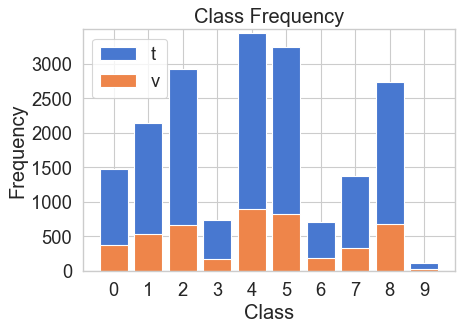

In [116]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
unique, counts = np.unique(y_val, return_counts=True)
plt.bar(unique, counts)

plt.title('Class Frequency')
plt.xlabel('Class')
plt.xticks(unique)
plt.ylabel('Frequency')
plt.ylim([0,3500])
plt.yticks(np.arange(0,3500,500))
plt.legend('tv',loc='best')

plt.show()

# Imbalanced Data Handling

### Re-Weighting

In [141]:
from sklearn.utils import class_weight
class_weights = dict(zip(np.unique(y_train), class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train))) 

C:\Users\farha\anaconda3\envs\yolov4-gpu\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5 6 7 8 9], y=[5 2 5 ... 1 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [146]:
class_weights

{0: 1.2759946055293325,
 1: 0.8850795135640785,
 2: 0.6460566746329806,
 3: 2.5571621621621623,
 4: 0.5483338162851348,
 5: 0.5836829117828501,
 6: 2.691749644381223,
 7: 1.371231884057971,
 8: 0.6918829981718464,
 9: 15.510655737704917}

### Data Augmentation & Random Over Sampling

In [142]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [143]:
datagen = ImageDataGenerator(rotation_range=10,brightness_range=[0.2,1.0])

In [125]:
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.tensorflow import balanced_batch_generator

class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
        
    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

In [148]:

balanced_gen = BalancedDataGenerator(X_train, y_train, datagen, batch_size=64)
balanced_gen_val = BalancedDataGenerator(X_val, y_val, datagen, batch_size=64)
steps_per_epoch = balanced_gen.steps_per_epoch

### Learning Rate Scheduler

In [127]:


class LossLearningRateScheduler(tf.keras.callbacks.History):
    """
    A learning rate scheduler that relies on changes in loss function
    value to dictate whether learning rate is decayed or not.
    LossLearningRateScheduler has the following properties:
    base_lr: the starting learning rate
    lookback_epochs: the number of epochs in the past to compare with the loss function at the current epoch to determine if progress is being made.
    decay_threshold / decay_multiple: if loss function has not improved by a factor of decay_threshold * lookback_epochs, then decay_multiple will be applied to the learning rate.
    spike_epochs: list of the epoch numbers where you want to spike the learning rate.
    spike_multiple: the multiple applied to the current learning rate for a spike.
    """

    def __init__(self, base_lr, lookback_epochs, spike_epochs = None, spike_multiple = 10, decay_threshold = 0.002, decay_multiple = 0.7, loss_type = 'val_loss'):

        super(LossLearningRateScheduler, self).__init__()

        self.base_lr = base_lr
        self.lookback_epochs = lookback_epochs
        self.spike_epochs = spike_epochs
        self.spike_multiple = spike_multiple
        self.decay_threshold = decay_threshold
        self.decay_multiple = decay_multiple
        self.loss_type = loss_type


    def on_epoch_begin(self, epoch, logs=None):

        if len(self.epoch) > self.lookback_epochs:

            current_lr = tf.keras.backend.get_value(self.model.optimizer.lr)

            target_loss = self.history[self.loss_type] 

            loss_diff =  target_loss[-int(self.lookback_epochs)] - target_loss[-1]

            if loss_diff <= np.abs(target_loss[-1]) * (self.decay_threshold * self.lookback_epochs):

                print(' '.join(('Changing learning rate from', str(current_lr), 'to', str(current_lr * self.decay_multiple))))
                tf.keras.backend.set_value(self.model.optimizer.lr, current_lr * self.decay_multiple)
                current_lr = current_lr * self.decay_multiple

            else:

                print(' '.join(('Learning rate:', str(current_lr))))

            if self.spike_epochs is not None and len(self.epoch) in self.spike_epochs:
                print(' '.join(('Spiking learning rate from', str(current_lr), 'to', str(current_lr * self.spike_multiple))))
                tf.keras.backend.set_value(self.model.optimizer.lr, current_lr * self.spike_multiple)

        else:

            print(' '.join(('Setting learning rate to', str(self.base_lr))))
            tf.keras.backend.set_value(self.model.optimizer.lr, self.base_lr)


        return tf.keras.backend.get_value(self.model.optimizer.lr)



In [149]:
callback_lr = LossLearningRateScheduler(base_lr=0.001, lookback_epochs=3)

## Focal Loss

In [164]:
from focal_loss import SparseCategoricalFocalLoss
# model.compile(loss=SparseCategoricalFocalLoss(gamma=2) ,optimizer=tfa.optimizers.LazyAdam(0.001), metrics=['accuracy'])

# Create Model, Training Phase, Testing Phase

In [151]:
model = create_model(input_image_shape)
model.compile(loss='sparse_categorical_crossentropy' ,optimizer=tfa.optimizers.LazyAdam(0.001), metrics=['accuracy'])
model.summary()

Model: "functional_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, None, None, 1536)  10783535  
_________________________________________________________________
batch_normalization_14 (Batc (None, 1, 1, 1536)        6144      
_________________________________________________________________
dropout_28 (Dropout)         (None, 1, 1, 1536)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 1536)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 256)               393472    
_________________________________________________________________
dropout_29 (Dropout)         (None, 256)             

In [152]:
filepath = 'best_model_cifar10.hdf5'
from tensorflow.keras.callbacks import Callback

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

stop = EarlyStopping(monitor='val_accuracy', patience =5,
                      verbose=0, mode='auto', baseline=None, 
                      restore_best_weights=False)

callbacks = [checkpoint,stop,callback_lr]
          
# history = model.fit(X_train, y_train, class_weight=class_weights,validation_data=(X_val, y_val),epochs=30,shuffle=True,
#           batch_size=128,callbacks=callbacks)
history = model.fit_generator(balanced_gen, steps_per_epoch, class_weight=class_weights,validation_data=balanced_gen_val,epochs=30,shuffle=True,
          callbacks=callbacks)
print("\n Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Setting learning rate to 0.001
Epoch 1/30
538/539 [============================>.] - ETA: 0s - loss: 2.3568 - accuracy: 0.4139
Epoch 00001: val_accuracy improved from -inf to 0.55510, saving model to best_model_cifar10.hdf5
539/539 [==============================] - 31s 58ms/step - loss: 2.3563 - accuracy: 0.4140 - val_loss: 1.3335 - val_accuracy: 0.5551
Setting learning rate to 0.001
Epoch 2/30
539/539 [==============================] - ETA: 0s - loss: 1.0393 - accuracy: 0.6497
Epoch 00002: val_accuracy improved from 0.55510 to 0.64240, saving model to best_model_cifar10.hdf5
539/539 [==============================] - 30s 56ms/step - loss: 1.0393 - accuracy: 0.6497 - val_loss: 1.0997 - val_accuracy: 0.6424
Setting learning rate to 0.001
Epoch 3/30
539/539 [==============================] - ETA: 0s - loss: 0.7026 - accuracy: 0.7500
Epoch 00003: val_accuracy improved from 0.64240 to 0.66016, saving model to best_model_cifar10.hdf5
539/539 [==============================] - 31s 57ms/step


0.76 acc efficientnetb3 longtailed dataset

# Plot Training Performance

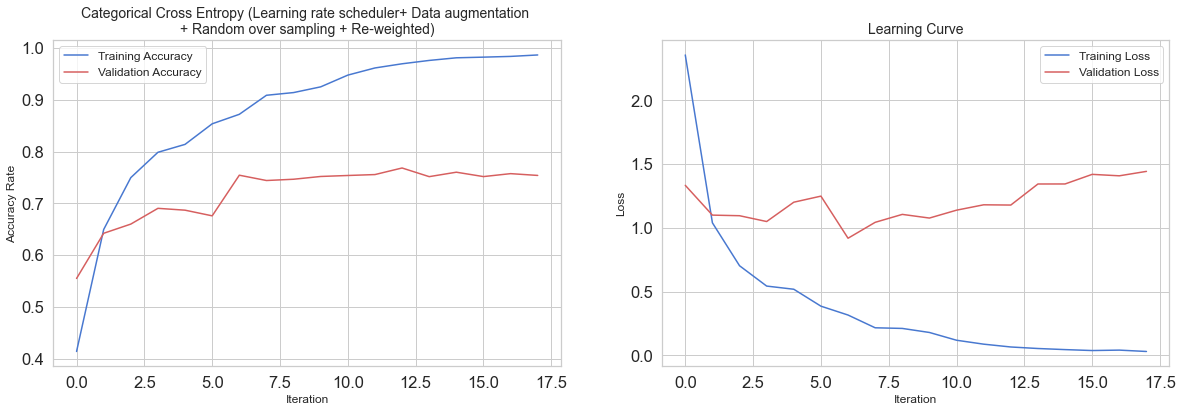

In [155]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2,figsize=(20,6))

ax1.plot(history.history['accuracy'],'b', history.history['val_accuracy'], 'r')
ax1.set_ylabel('Accuracy Rate',fontsize=12)
ax1.set_xlabel('Iteration',fontsize=12)
ax1.set_title('Categorical Cross Entropy (Learning rate scheduler+ Data augmentation \n+ Random over sampling + Re-weighted)',fontsize=14)

ax1.legend(['Training Accuracy','Validation Accuracy'],fontsize=12,loc='best')

ax2.plot(history.history['loss'], 'b',history.history['val_loss'],'r')
ax2.set_ylabel('Loss',fontsize=12)
ax2.set_xlabel('Iteration',fontsize=12)
ax2.set_title('Learning Curve',fontsize=14)
ax2.legend(['Training Loss','Validation Loss'],fontsize=12,loc='best')

# plt.savefig('crosse_results.png')
plt.show()

In [52]:
from sklearn import metrics
import seaborn as sns

# Confusion Matrix

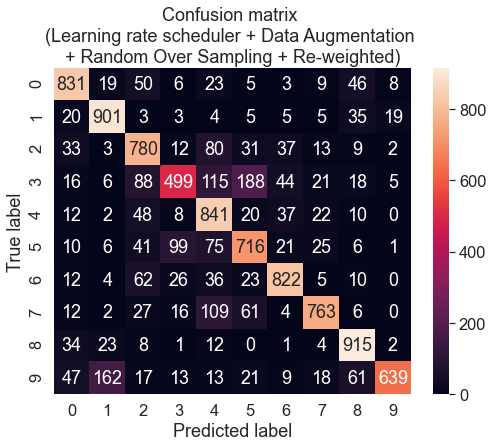

In [162]:
model = load_model('best_model_cifar10.hdf5')

y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = y_test
confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)
# print(y_true_labels)
LABELS = np.unique(y_test).astype('str')

plt.figure(figsize=(8, 6))
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix \n(Learning rate scheduler + Data Augmentation \n+ Random Over Sampling + Re-weighted)")
plt.ylabel('True label')
# plt.ylim((16,14))
plt.xlabel('Predicted label')
plt.show();

In [163]:
print(metrics.classification_report(y_true_labels, y_pred_labels, target_names=LABELS))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1000
           1       0.80      0.90      0.85      1000
           2       0.69      0.78      0.73      1000
           3       0.73      0.50      0.59      1000
           4       0.64      0.84      0.73      1000
           5       0.67      0.72      0.69      1000
           6       0.84      0.82      0.83      1000
           7       0.86      0.76      0.81      1000
           8       0.82      0.92      0.86      1000
           9       0.95      0.64      0.76      1000

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.77      0.77     10000

